<h1 style=font:garmond;font-size:50px;color:orange;text-align:left>Predict ML</h1>

In [1]:
import time
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.models import Sequential
from datetime import datetime
from main import collect, compare_precision

<h2 style=font:garmond;font-size:36px;color:orange;text-align:left>Transformation</h2>

In [2]:
df = pd.read_csv('data.csv')
scaler = StandardScaler().fit(df.values)
transformed_dataset = scaler.transform(df.values)
transformed_dataframe = pd.DataFrame(data=transformed_dataset, index=df.index)

In [3]:
number_of_rows: int = df.values.shape[0]
number_of_features: int = df.values.shape[1]
window_size: int = 35

<h2 style=font:garmond;font-size:36px;color:orange;text-align:left>Training</h2>

In [4]:
LSTM_NODES: int = 240
DENSE_LAYERS: int = number_of_features
DROPOUT_VARIANCE: float = 0.2

In [5]:
model = Sequential()
model.add(Bidirectional(LSTM(LSTM_NODES, input_shape=(window_size, number_of_features), return_sequences=True)))
model.add(Dropout(DROPOUT_VARIANCE))
model.add(Bidirectional(LSTM(LSTM_NODES, input_shape=(window_size, number_of_features), return_sequences=True)))
model.add(Dropout(DROPOUT_VARIANCE))
model.add(Bidirectional(LSTM(LSTM_NODES, input_shape=(window_size, number_of_features), return_sequences=True)))
model.add(Bidirectional(LSTM(LSTM_NODES, input_shape=(window_size, number_of_features), return_sequences=False)))
model.add(Dense(DENSE_LAYERS))
model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])    # NOQA

In [6]:
train = np.empty([number_of_rows-window_size, window_size, number_of_features], dtype=float)
label = np.empty([number_of_rows-window_size, number_of_features], dtype=float)

for i in range(0, number_of_rows-window_size):
    train[i]=transformed_dataframe.iloc[i:i+window_size, 0: number_of_features]
    label[i]=transformed_dataframe.iloc[i+window_size: i+window_size+1, 0: number_of_features]

In [7]:
st: float = time.time()

batch_size: int = 32
epochs: int = 100

history = model.fit(train, label, batch_size=batch_size, epochs=epochs)

print(f'\nTime elapsed: {round(time.time()-st, 3)}s')

Epoch 1/250
64/64 [==============================] - 16s 135ms/step - loss: 1.0134 - accuracy: 0.1620
Epoch 2/250
64/64 [==============================] - 7s 115ms/step - loss: 1.0054 - accuracy: 0.1669
Epoch 3/250
64/64 [==============================] - 7s 116ms/step - loss: 1.0046 - accuracy: 0.1630
Epoch 4/250
64/64 [==============================] - 7s 116ms/step - loss: 1.0045 - accuracy: 0.1615
Epoch 5/250
64/64 [==============================] - 7s 116ms/step - loss: 1.0045 - accuracy: 0.1615
Epoch 6/250
64/64 [==============================] - 7s 117ms/step - loss: 1.0006 - accuracy: 0.1787
Epoch 7/250
64/64 [==============================] - 8s 117ms/step - loss: 0.9994 - accuracy: 0.1689
Epoch 8/250
64/64 [==============================] - 7s 117ms/step - loss: 0.9978 - accuracy: 0.1782
Epoch 9/250
64/64 [==============================] - 7s 117ms/step - loss: 0.9933 - accuracy: 0.1787
Epoch 10/250
64/64 [==============================] - 7s 117ms/step - loss: 0.9954 - accur

<h2 style=font:garmond;font-size:36px;color:orange;text-align:left>Prediction</h2>


In [8]:
st: float = time.time()

to_predict = np.array(df.iloc[-window_size:])
scaled_to_predict = scaler.transform(to_predict)

scaled_prediction = model.predict(np.array([scaled_to_predict]))
np_prediction = scaler.inverse_transform(scaled_prediction).astype(int)[0]

print(*np_prediction, sep=', ')

print(f'\nTime elapsed: {round(time.time()-st, 3)}s')

1/1 [==============================] - 3s 3s/step
7, 12, 18, 24, 31, 38

Time elapsed: 3.362s


<h2 style=font:garmond;font-size:36px;color:orange;text-align:left>Result</h2>

In [9]:
st: float = time.time()

prediction = list(np_prediction)
target: list = collect(len(df) + 2)

precision: float = compare_precision(prediction, target)

print(f'\nTime elapsed: {round(time.time()-st, 3)}s')

Precision = 70%

Prediction:
7 - 12 - 18 - 24 - 31 - 38

Target:
14 - 21 - 26 - 35 - 37 - 40

Time elapsed: 0.617s


In [10]:
with open('storage.csv', 'a', encoding='UTF-8', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(np_prediction)

column_names: list = ['A', 'B', 'C', 'D', 'E', 'F']
df2 = pd.read_csv('storage.csv', names=column_names)

print(df2.iloc[-6:])

    A   B   C   D   E   F
12  5  13  18  25  31  41
13  4  10  15  22  31  37
14  5  14  19  29  30  38
15  4  12  18  23  32  39
16  6  13  17  24  29  39
17  7  12  18  24  31  38


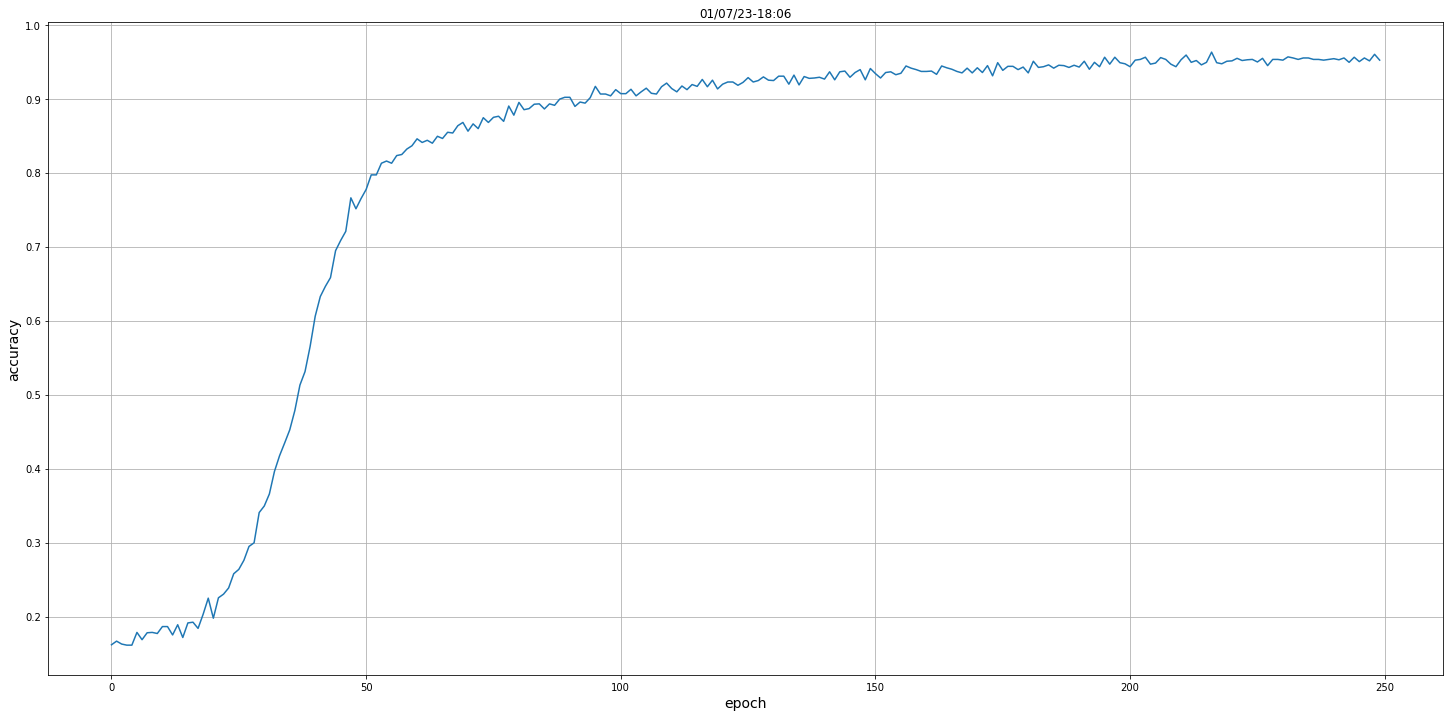

In [11]:
today: datetime = datetime.today()
now: datetime = datetime.now()

date_formatted: str = today.strftime('%m/%d/%y')
time_formatted: str = now.strftime('%H:%M')
title: str = f'{date_formatted}-{time_formatted}'

plt.figure(figsize=(25, 12))
plt.plot(history.history['accuracy'])
plt.title(title)
plt.ylabel('accuracy', fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.grid()
plt.show()